<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [174]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res = ice.fit_transform(X_nan)
       #print("fin res ", res)
       return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      #print(m_bool)
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      #print("matrices computed")
      #print(sigma_aa_inv)
      #print(sigma_ma)
      #print("wee", x_c[m_bool])
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      #print("mu cond ", mu_cond)
      x_imp[i, ~m_bool] = mu_cond
    #print("x_orig \n", x)
    #print("x_imp \n", x_imp)
    #print("diff\n", x - x_imp)
  return x_imp

#n = 3
#d = 4
#S = np.random.randint(low=1, high=10, size=(d, d))
#S = S.T @ S * 0 + np.eye(d)
#print(S)
#muu = np.array([10, 20, 30, 40])
#xx = np.random.randint(low=1, high=6, size=(n, d))
#mm = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]])
#print(xx)
#print(mm)
#x, m = clear_dataset(xx, mm)
#print("cleaned ds \n", x)
#print("cleaned masks \n", mm)
#res = imputation_elliptic(muu, S, x, m)


In [175]:
# define observations

n = 400
d = 6
X_orig = np.random.rand(n, d)
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
#print(masks)
#print(X_orig)
#print(X_nan)
print("end block")

final shape  (400, 6)
end block


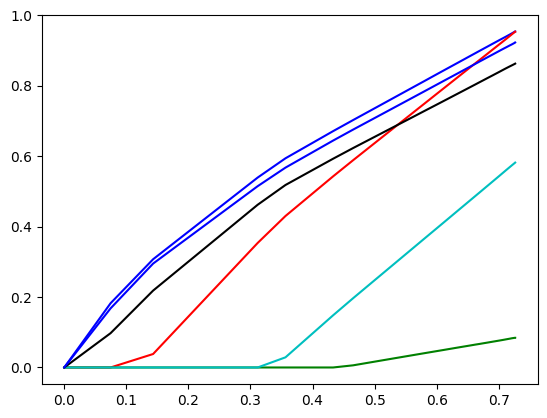

In [176]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

  0%|          | 0/200 [00:00<?, ?it/s]

alpha   0.0001


  4%|▎         | 7/200 [00:00<00:02, 67.73it/s]

alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195
alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457
alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092
alpha   0.00018896523396912096
alpha   0.00020022003718155845
alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583


  8%|▊         | 16/200 [00:00<00:02, 79.88it/s]

alpha   0.0002523539170434766
alpha   0.0002673841615839947


 12%|█▎        | 25/200 [00:00<00:02, 82.36it/s]

alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929
alpha   0.0004008806328898465
alpha   0.00042475715525368984
alpha   0.00045005576757004977
alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381
alpha   0.0006368249944718586
alpha   0.0006747544053110693


 21%|██        | 42/200 [00:00<00:02, 73.09it/s]

alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677
alpha   0.0009011018251665018
alpha   0.0009547716114208056
alpha   0.001011637979766207
alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279
alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384


 29%|██▉       | 58/200 [00:00<00:01, 73.98it/s]

alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036
alpha   0.0020255019392306666
alpha   0.0021461411978584057
alpha   0.0022739657523579274
alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605
alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828


 38%|███▊      | 75/200 [00:00<00:01, 76.48it/s]

alpha   0.004297004704320844
alpha   0.004552935074866948
alpha   0.004824108704165373
alpha   0.005111433483440166
alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393
alpha   0.007232633896483534
alpha   0.007663410868007463
alpha   0.008119844993184008
alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708
alpha   0.010234114021054537


 46%|████▌     | 91/200 [00:01<00:01, 75.31it/s]

alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072
alpha   0.014481182276745346
alpha   0.015343684089300131
alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444
alpha   0.01933891750455232
alpha   0.020490746898158482
alpha   0.021711179456945052
alpha   0.023004301197729192
alpha   0.024374441501222217
alpha   0.025826187606826773


 54%|█████▎    | 107/200 [00:01<00:01, 72.07it/s]

alpha   0.02736439997074672
alpha   0.02899422853882878
alpha   0.03072112998861759
alpha   0.0325508859983506
alpha   0.0344896226040576
alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108
alpha   0.04880251583654434
alpha   0.05170920242896761
alpha   0.05478901179593945
alpha   0.058052255160949015


 57%|█████▊    | 115/200 [00:01<00:01, 71.08it/s]

alpha   0.06150985788580504
alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272
alpha   0.07752597488629465
alpha   0.0821434358491943
alpha   0.08703591361485166
alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384
alpha   0.1162322468679853


 62%|██████▏   | 123/200 [00:01<00:01, 66.69it/s]

alpha   0.12315506032928261


 65%|██████▌   | 130/200 [00:01<00:01, 58.81it/s]

alpha   0.1304901978014403
alpha   0.13826221737646563
alpha   0.14649713983072862
alpha   0.1552225357427048
alpha   0.16446761779946645
alpha   0.17426333860096507
alpha   0.18464249428955445
alpha   0.19563983435170648
alpha   0.2072921779595372


 68%|██████▊   | 137/200 [00:02<00:01, 45.77it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098
alpha   0.2465811075822604
alpha   0.2612675225563329
alpha   0.27682866303920667
alpha   0.29331662783900453
alpha   0.3107866187782014


 72%|███████▏  | 143/200 [00:02<00:01, 45.55it/s]

alpha   0.3292971255097151
alpha   0.3489101213406774
alpha   0.3696912707195028
alpha   0.39171014908092605
alpha   0.41504047578504766
alpha   0.4397603609302721
alpha   0.4659525668664682
alpha   0.4937047852839004


 74%|███████▍  | 148/200 [00:02<00:01, 33.31it/s]

alpha   0.5231099308056264
alpha   0.5542664520663108
alpha   0.5872786613189482


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


alpha   0.6222570836730231


 76%|███████▌  | 152/200 [00:04<00:06,  7.64it/s]

alpha   0.6593188271333549
alpha   0.698587974678525
alpha   0.7401959996915645


 78%|███████▊  | 155/200 [00:05<00:08,  5.18it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395
alpha   0.8804883581643465


 79%|███████▉  | 158/200 [00:07<00:09,  4.25it/s]

alpha   0.9329304026284686
alpha   0.9884959046625587


 80%|████████  | 160/200 [00:07<00:10,  3.76it/s]

alpha   1.0473708979594507
alpha   1.1097524964120722


 81%|████████  | 162/200 [00:09<00:12,  2.95it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:10<00:14,  2.52it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:10<00:14,  2.53it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:10<00:13,  2.58it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:11<00:12,  2.70it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:11<00:11,  2.87it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:11<00:10,  3.16it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:11<00:09,  3.38it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:12<00:10,  2.86it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:12<00:09,  2.93it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:13<00:09,  2.94it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:13<00:10,  2.64it/s]

alpha   2.2219468609395236


 87%|████████▋ | 174/200 [00:13<00:09,  2.81it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:14<00:09,  2.51it/s]

alpha   2.4945081352303164


 88%|████████▊ | 176/200 [00:14<00:09,  2.51it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:15<00:09,  2.52it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:15<00:09,  2.37it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:16<00:09,  2.29it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:16<00:09,  2.20it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:17<00:08,  2.16it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:17<00:08,  2.11it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:17<00:08,  2.12it/s]

alpha   3.9626886387014784


 92%|█████████▏| 184/200 [00:18<00:07,  2.08it/s]

alpha   4.198707084443915


 92%|█████████▎| 185/200 [00:18<00:07,  2.09it/s]

alpha   4.448782831127585


 93%|█████████▎| 186/200 [00:19<00:06,  2.05it/s]

alpha   4.713753134116729


 94%|█████████▎| 187/200 [00:19<00:06,  2.07it/s]

alpha   4.99450511585514


 94%|█████████▍| 188/200 [00:20<00:05,  2.04it/s]

alpha   5.291978735958447


 94%|█████████▍| 189/200 [00:21<00:06,  1.75it/s]

alpha   5.607169938205458


 95%|█████████▌| 190/200 [00:22<00:06,  1.54it/s]

alpha   5.94113398496504


 96%|█████████▌| 191/200 [00:22<00:06,  1.43it/s]

alpha   6.294988990221888


 96%|█████████▌| 192/200 [00:23<00:05,  1.38it/s]

alpha   6.669919663030129


 96%|█████████▋| 193/200 [00:24<00:04,  1.54it/s]

alpha   7.067181273927491


 97%|█████████▋| 194/200 [00:24<00:03,  1.64it/s]

alpha   7.488103857590031


 98%|█████████▊| 195/200 [00:25<00:02,  1.76it/s]

alpha   7.934096665797492


 98%|█████████▊| 196/200 [00:25<00:02,  1.83it/s]

alpha   8.406652885618334


 98%|█████████▊| 197/200 [00:26<00:01,  1.90it/s]

alpha   8.907354638610439


 99%|█████████▉| 198/200 [00:26<00:01,  1.94it/s]

alpha   9.437878277775392


100%|█████████▉| 199/200 [00:27<00:00,  1.98it/s]

alpha   10.0


100%|██████████| 200/200 [00:27<00:00,  7.26it/s]


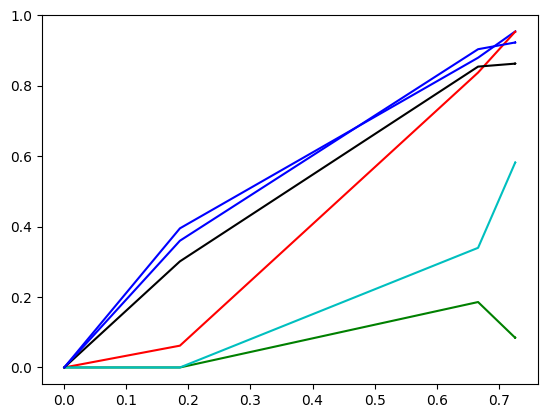

In [177]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X_orig, y, np.eye(X_orig.shape[1]), p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(400, 6)
std_orig: 
 [0.28630483 0.28878512 0.28695097 0.29993485 0.28041108 0.28129841]
std rf
  [0.26157681 0.26167647 0.2614959  0.26380727 0.2558971  0.25645591]


  3%|▎         | 6/200 [00:00<00:03, 51.50it/s]

alpha   0.0001
alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195
alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457
alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092


 10%|▉         | 19/200 [00:00<00:03, 58.08it/s]

alpha   0.00018896523396912096
alpha   0.00020022003718155845
alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583
alpha   0.0002523539170434766
alpha   0.0002673841615839947
alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929


 16%|█▋        | 33/200 [00:00<00:02, 64.11it/s]

alpha   0.0004008806328898465
alpha   0.00042475715525368984
alpha   0.00045005576757004977
alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381
alpha   0.0006368249944718586
alpha   0.0006747544053110693
alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677


 24%|██▎       | 47/200 [00:00<00:02, 66.43it/s]

alpha   0.0009011018251665018
alpha   0.0009547716114208056
alpha   0.001011637979766207
alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279
alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384
alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036


 30%|███       | 61/200 [00:00<00:02, 66.33it/s]

alpha   0.0020255019392306666
alpha   0.0021461411978584057
alpha   0.0022739657523579274
alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605
alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828
alpha   0.004297004704320844
alpha   0.004552935074866948


 38%|███▊      | 76/200 [00:01<00:01, 67.80it/s]

alpha   0.004824108704165373
alpha   0.005111433483440166
alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393
alpha   0.007232633896483534
alpha   0.007663410868007463
alpha   0.008119844993184008
alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708


 45%|████▌     | 90/200 [00:01<00:01, 58.21it/s]

alpha   0.010234114021054537
alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072
alpha   0.014481182276745346
alpha   0.015343684089300131
alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444


 48%|████▊     | 96/200 [00:01<00:01, 55.49it/s]

alpha   0.01933891750455232
alpha   0.020490746898158482
alpha   0.021711179456945052
alpha   0.023004301197729192
alpha   0.024374441501222217
alpha   0.025826187606826773
alpha   0.02736439997074672
alpha   0.02899422853882878


 54%|█████▍    | 108/200 [00:01<00:01, 47.80it/s]

alpha   0.03072112998861759
alpha   0.0325508859983506
alpha   0.0344896226040576
alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108
alpha   0.04880251583654434
alpha   0.05170920242896761


 56%|█████▋    | 113/200 [00:02<00:02, 42.70it/s]

alpha   0.05478901179593945
alpha   0.058052255160949015
alpha   0.06150985788580504
alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272
alpha   0.07752597488629465


 62%|██████▏   | 123/200 [00:02<00:01, 39.95it/s]

alpha   0.0821434358491943
alpha   0.08703591361485166
alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384
alpha   0.1162322468679853
alpha   0.12315506032928261
alpha   0.1304901978014403
alpha   0.13826221737646563
alpha   0.14649713983072862


 64%|██████▍   | 128/200 [00:02<00:03, 21.11it/s]

alpha   0.1552225357427048
alpha   0.16446761779946645
alpha   0.17426333860096507
alpha   0.18464249428955445


 66%|██████▌   | 132/200 [00:03<00:04, 14.86it/s]

alpha   0.19563983435170648
alpha   0.2072921779595372


 68%|██████▊   | 135/200 [00:03<00:04, 14.25it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098
alpha   0.2465811075822604


 69%|██████▉   | 138/200 [00:03<00:04, 14.15it/s]

alpha   0.2612675225563329
alpha   0.27682866303920667
alpha   0.29331662783900453


 70%|███████   | 140/200 [00:04<00:04, 12.31it/s]

alpha   0.3107866187782014
alpha   0.3292971255097151


 71%|███████   | 142/200 [00:04<00:05, 10.22it/s]

alpha   0.3489101213406774
alpha   0.3696912707195028


 72%|███████▏  | 144/200 [00:04<00:06,  8.72it/s]

alpha   0.39171014908092605
alpha   0.41504047578504766
alpha   0.4397603609302721


 73%|███████▎  | 146/200 [00:05<00:07,  7.10it/s]

alpha   0.4659525668664682


 74%|███████▎  | 147/200 [00:05<00:08,  6.48it/s]

alpha   0.4937047852839004


 74%|███████▍  | 149/200 [00:05<00:08,  5.88it/s]

alpha   0.5231099308056264
alpha   0.5542664520663108


 75%|███████▌  | 150/200 [00:06<00:08,  5.59it/s]

alpha   0.5872786613189482


 76%|███████▌  | 151/200 [00:06<00:09,  5.29it/s]

alpha   0.6222570836730231


 76%|███████▌  | 152/200 [00:06<00:09,  5.07it/s]

alpha   0.6593188271333549


 76%|███████▋  | 153/200 [00:06<00:11,  4.17it/s]

alpha   0.698587974678525


 77%|███████▋  | 154/200 [00:07<00:12,  3.80it/s]

alpha   0.7401959996915645


 78%|███████▊  | 156/200 [00:07<00:10,  4.06it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395


 78%|███████▊  | 157/200 [00:08<00:13,  3.13it/s]

alpha   0.8804883581643465


 79%|███████▉  | 158/200 [00:08<00:14,  2.99it/s]

alpha   0.9329304026284686


 80%|███████▉  | 159/200 [00:08<00:13,  3.05it/s]

alpha   0.9884959046625587


 80%|████████  | 160/200 [00:09<00:11,  3.37it/s]

alpha   1.0473708979594507


 80%|████████  | 161/200 [00:09<00:11,  3.30it/s]

alpha   1.1097524964120722


 81%|████████  | 162/200 [00:09<00:12,  3.05it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:09<00:11,  3.31it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:10<00:10,  3.39it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:10<00:10,  3.39it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:10<00:10,  3.35it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:11<00:10,  3.19it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:11<00:10,  3.14it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:11<00:09,  3.20it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:12<00:10,  2.99it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:12<00:10,  2.85it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:12<00:10,  2.75it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:13<00:09,  2.82it/s]

alpha   2.2219468609395236


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 87%|████████▋ | 174/200 [00:13<00:10,  2.55it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:14<00:10,  2.39it/s]

alpha   2.4945081352303164


 88%|████████▊ | 176/200 [00:14<00:10,  2.29it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:15<00:10,  2.21it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:15<00:09,  2.23it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:16<00:09,  2.16it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:16<00:09,  2.19it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:17<00:08,  2.16it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:17<00:08,  2.15it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:18<00:08,  2.12it/s]

alpha   3.9626886387014784


 92%|█████████▏| 184/200 [00:18<00:08,  1.78it/s]

alpha   4.198707084443915


 92%|█████████▎| 185/200 [00:19<00:09,  1.55it/s]

alpha   4.448782831127585


 93%|█████████▎| 186/200 [00:20<00:09,  1.44it/s]

alpha   4.713753134116729


 94%|█████████▎| 187/200 [00:21<00:09,  1.41it/s]

alpha   4.99450511585514


 94%|█████████▍| 188/200 [00:21<00:07,  1.55it/s]

alpha   5.291978735958447


 94%|█████████▍| 189/200 [00:22<00:06,  1.68it/s]

alpha   5.607169938205458


 95%|█████████▌| 190/200 [00:22<00:05,  1.77it/s]

alpha   5.94113398496504


 96%|█████████▌| 191/200 [00:23<00:04,  1.86it/s]

alpha   6.294988990221888


 96%|█████████▌| 192/200 [00:23<00:04,  1.90it/s]

alpha   6.669919663030129


 96%|█████████▋| 193/200 [00:24<00:03,  1.95it/s]

alpha   7.067181273927491


 97%|█████████▋| 194/200 [00:24<00:03,  1.97it/s]

alpha   7.488103857590031


 98%|█████████▊| 195/200 [00:25<00:02,  2.00it/s]

alpha   7.934096665797492


 98%|█████████▊| 196/200 [00:25<00:02,  1.99it/s]

alpha   8.406652885618334


 98%|█████████▊| 197/200 [00:26<00:01,  2.00it/s]

alpha   8.907354638610439


 99%|█████████▉| 198/200 [00:26<00:00,  2.01it/s]

alpha   9.437878277775392


100%|█████████▉| 199/200 [00:27<00:00,  2.02it/s]

alpha   10.0


100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


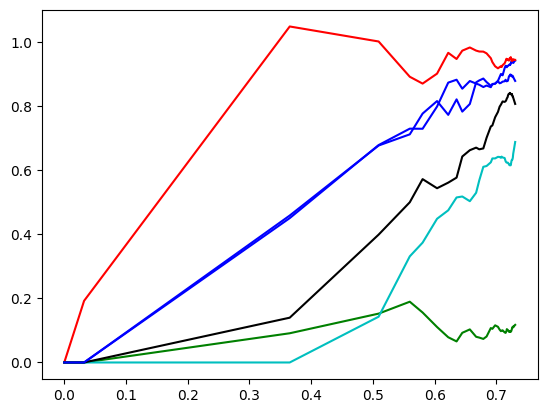

In [178]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


std_orig: 
 [0.28630483 0.28878512 0.28695097 0.29993485 0.28041108 0.28129841]
std  br
  [0.25044204 0.25053992 0.24698062 0.24853578 0.24566377 0.24384951]


  4%|▎         | 7/200 [00:00<00:03, 60.92it/s]

alpha   0.0001
alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195
alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457
alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092
alpha   0.00018896523396912096
alpha   0.00020022003718155845


 10%|█         | 21/200 [00:00<00:02, 64.47it/s]

alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583
alpha   0.0002523539170434766
alpha   0.0002673841615839947
alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929
alpha   0.0004008806328898465
alpha   0.00042475715525368984
alpha   0.00045005576757004977


 18%|█▊        | 35/200 [00:00<00:02, 66.70it/s]

alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381
alpha   0.0006368249944718586
alpha   0.0006747544053110693
alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677
alpha   0.0009011018251665018
alpha   0.0009547716114208056
alpha   0.001011637979766207


 25%|██▌       | 50/200 [00:00<00:02, 68.38it/s]

alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279
alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384
alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036
alpha   0.0020255019392306666
alpha   0.0021461411978584057
alpha   0.0022739657523579274


 32%|███▏      | 64/200 [00:00<00:02, 66.69it/s]

alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605
alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828
alpha   0.004297004704320844
alpha   0.004552935074866948
alpha   0.004824108704165373
alpha   0.005111433483440166


 39%|███▉      | 78/200 [00:01<00:01, 65.25it/s]

alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393
alpha   0.007232633896483534
alpha   0.007663410868007463
alpha   0.008119844993184008
alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708
alpha   0.010234114021054537


 46%|████▌     | 92/200 [00:01<00:01, 58.19it/s]

alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072
alpha   0.014481182276745346
alpha   0.015343684089300131
alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444
alpha   0.01933891750455232
alpha   0.020490746898158482


 49%|████▉     | 98/200 [00:01<00:02, 50.92it/s]

alpha   0.021711179456945052
alpha   0.023004301197729192
alpha   0.024374441501222217
alpha   0.025826187606826773
alpha   0.02736439997074672
alpha   0.02899422853882878
alpha   0.03072112998861759
alpha   0.0325508859983506


 52%|█████▏    | 104/200 [00:01<00:01, 50.21it/s]

alpha   0.0344896226040576
alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108
alpha   0.04880251583654434
alpha   0.05170920242896761
alpha   0.05478901179593945


 57%|█████▊    | 115/200 [00:02<00:02, 40.82it/s]

alpha   0.058052255160949015
alpha   0.06150985788580504
alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272
alpha   0.07752597488629465
alpha   0.0821434358491943


 60%|██████    | 120/200 [00:02<00:02, 37.96it/s]

alpha   0.08703591361485166
alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384
alpha   0.1162322468679853
alpha   0.12315506032928261


 62%|██████▏   | 124/200 [00:02<00:02, 35.68it/s]

alpha   0.1304901978014403
alpha   0.13826221737646563
alpha   0.14649713983072862


 64%|██████▍   | 128/200 [00:02<00:03, 20.26it/s]

alpha   0.1552225357427048
alpha   0.16446761779946645
alpha   0.17426333860096507
alpha   0.18464249428955445


 66%|██████▌   | 131/200 [00:03<00:04, 14.90it/s]

alpha   0.19563983435170648
alpha   0.2072921779595372


 67%|██████▋   | 134/200 [00:03<00:05, 11.80it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098


 68%|██████▊   | 136/200 [00:03<00:05, 11.05it/s]

alpha   0.2465811075822604
alpha   0.2612675225563329


 69%|██████▉   | 138/200 [00:04<00:06, 10.17it/s]

alpha   0.27682866303920667
alpha   0.29331662783900453
alpha   0.3107866187782014


 70%|███████   | 140/200 [00:04<00:07,  7.83it/s]

alpha   0.3292971255097151


 71%|███████   | 142/200 [00:04<00:07,  7.26it/s]

alpha   0.3489101213406774
alpha   0.3696912707195028


 72%|███████▏  | 144/200 [00:05<00:08,  6.70it/s]

alpha   0.39171014908092605
alpha   0.41504047578504766


 72%|███████▎  | 145/200 [00:05<00:08,  6.20it/s]

alpha   0.4397603609302721


 73%|███████▎  | 146/200 [00:05<00:09,  5.81it/s]

alpha   0.4659525668664682


 74%|███████▎  | 147/200 [00:05<00:09,  5.50it/s]

alpha   0.4937047852839004


 74%|███████▍  | 148/200 [00:06<00:09,  5.32it/s]

alpha   0.5231099308056264


 75%|███████▌  | 150/200 [00:06<00:08,  5.73it/s]

alpha   0.5542664520663108
alpha   0.5872786613189482


 76%|███████▌  | 152/200 [00:06<00:06,  7.04it/s]

alpha   0.6222570836730231
alpha   0.6593188271333549


 77%|███████▋  | 154/200 [00:06<00:07,  6.50it/s]

alpha   0.698587974678525
alpha   0.7401959996915645


 78%|███████▊  | 156/200 [00:07<00:06,  6.87it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395


 78%|███████▊  | 157/200 [00:07<00:07,  5.74it/s]

alpha   0.8804883581643465


 80%|███████▉  | 159/200 [00:07<00:07,  5.29it/s]

alpha   0.9329304026284686
alpha   0.9884959046625587


 80%|████████  | 160/200 [00:08<00:06,  5.87it/s]

alpha   1.0473708979594507


 80%|████████  | 161/200 [00:08<00:10,  3.79it/s]

alpha   1.1097524964120722


 81%|████████  | 162/200 [00:09<00:13,  2.79it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:09<00:12,  2.88it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:09<00:11,  3.06it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:10<00:11,  3.15it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:10<00:10,  3.17it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:10<00:10,  3.04it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:11<00:10,  3.03it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:11<00:09,  3.11it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:11<00:10,  2.95it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:12<00:10,  2.82it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:12<00:10,  2.74it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:12<00:09,  2.82it/s]

alpha   2.2219468609395236


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 87%|████████▋ | 174/200 [00:13<00:10,  2.53it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:13<00:10,  2.38it/s]

alpha   2.4945081352303164


 88%|████████▊ | 176/200 [00:14<00:10,  2.28it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:14<00:10,  2.21it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:15<00:09,  2.23it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:15<00:09,  2.17it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:16<00:09,  2.20it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:16<00:09,  1.91it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:17<00:11,  1.63it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:18<00:11,  1.51it/s]

alpha   3.9626886387014784


 92%|█████████▏| 184/200 [00:19<00:11,  1.39it/s]

alpha   4.198707084443915


 92%|█████████▎| 185/200 [00:19<00:09,  1.51it/s]

alpha   4.448782831127585


 93%|█████████▎| 186/200 [00:20<00:08,  1.63it/s]

alpha   4.713753134116729


 94%|█████████▎| 187/200 [00:20<00:07,  1.75it/s]

alpha   4.99450511585514


 94%|█████████▍| 188/200 [00:21<00:06,  1.82it/s]

alpha   5.291978735958447


 94%|█████████▍| 189/200 [00:21<00:05,  1.88it/s]

alpha   5.607169938205458


 95%|█████████▌| 190/200 [00:22<00:05,  1.91it/s]

alpha   5.94113398496504


 96%|█████████▌| 191/200 [00:22<00:04,  1.96it/s]

alpha   6.294988990221888


 96%|█████████▌| 192/200 [00:23<00:04,  1.97it/s]

alpha   6.669919663030129


 96%|█████████▋| 193/200 [00:23<00:03,  1.99it/s]

alpha   7.067181273927491


 97%|█████████▋| 194/200 [00:24<00:03,  1.99it/s]

alpha   7.488103857590031


 98%|█████████▊| 195/200 [00:24<00:02,  2.01it/s]

alpha   7.934096665797492


 98%|█████████▊| 196/200 [00:25<00:01,  2.01it/s]

alpha   8.406652885618334


 98%|█████████▊| 197/200 [00:25<00:01,  2.03it/s]

alpha   8.907354638610439


 99%|█████████▉| 198/200 [00:26<00:00,  2.02it/s]

alpha   9.437878277775392


100%|█████████▉| 199/200 [00:26<00:00,  2.05it/s]

alpha   10.0


100%|██████████| 200/200 [00:27<00:00,  7.37it/s]


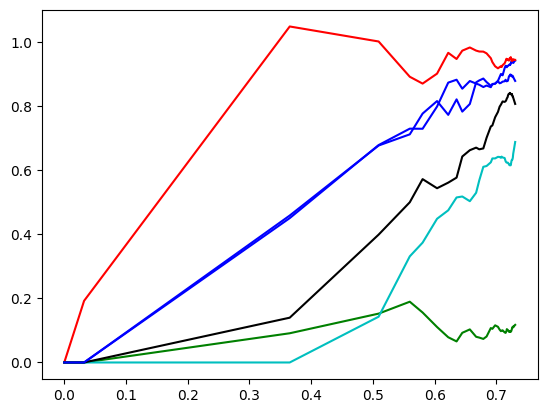

In [179]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

[0.25044175 0.25053989 0.24698054 0.24853564 0.24566359 0.24384942]


  3%|▎         | 6/200 [00:00<00:03, 54.90it/s]

alpha   0.0001
alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195
alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457
alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092
alpha   0.00018896523396912096


 10%|█         | 20/200 [00:00<00:02, 63.00it/s]

alpha   0.00020022003718155845
alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583
alpha   0.0002523539170434766
alpha   0.0002673841615839947
alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929
alpha   0.0004008806328898465
alpha   0.00042475715525368984


 17%|█▋        | 34/200 [00:00<00:02, 66.44it/s]

alpha   0.00045005576757004977
alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381
alpha   0.0006368249944718586
alpha   0.0006747544053110693
alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677
alpha   0.0009011018251665018
alpha   0.0009547716114208056
alpha   0.001011637979766207


 24%|██▍       | 49/200 [00:00<00:02, 69.47it/s]

alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279
alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384
alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036
alpha   0.0020255019392306666
alpha   0.0021461411978584057


 32%|███▏      | 63/200 [00:00<00:02, 64.65it/s]

alpha   0.0022739657523579274
alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605
alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828
alpha   0.004297004704320844
alpha   0.004552935074866948
alpha   0.004824108704165373


 35%|███▌      | 70/200 [00:01<00:02, 64.89it/s]

alpha   0.005111433483440166
alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393
alpha   0.007232633896483534
alpha   0.007663410868007463
alpha   0.008119844993184008


 42%|████▏     | 83/200 [00:01<00:02, 53.49it/s]

alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708
alpha   0.010234114021054537
alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072


 44%|████▍     | 89/200 [00:01<00:02, 46.17it/s]

alpha   0.014481182276745346
alpha   0.015343684089300131
alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444
alpha   0.01933891750455232
alpha   0.020490746898158482
alpha   0.021711179456945052


 50%|████▉     | 99/200 [00:01<00:02, 41.79it/s]

alpha   0.023004301197729192
alpha   0.024374441501222217
alpha   0.025826187606826773
alpha   0.02736439997074672
alpha   0.02899422853882878
alpha   0.03072112998861759
alpha   0.0325508859983506
alpha   0.0344896226040576


 55%|█████▌    | 110/200 [00:02<00:02, 42.62it/s]

alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108
alpha   0.04880251583654434
alpha   0.05170920242896761
alpha   0.05478901179593945
alpha   0.058052255160949015
alpha   0.06150985788580504


 57%|█████▊    | 115/200 [00:02<00:02, 36.46it/s]

alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272
alpha   0.07752597488629465
alpha   0.0821434358491943
alpha   0.08703591361485166


 60%|█████▉    | 119/200 [00:02<00:02, 33.07it/s]

alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384


 62%|██████▏   | 123/200 [00:02<00:03, 25.28it/s]

alpha   0.1162322468679853
alpha   0.12315506032928261
alpha   0.1304901978014403


 63%|██████▎   | 126/200 [00:02<00:03, 19.12it/s]

alpha   0.13826221737646563
alpha   0.14649713983072862
alpha   0.1552225357427048
alpha   0.16446761779946645


 64%|██████▍   | 129/200 [00:03<00:04, 14.84it/s]

alpha   0.17426333860096507
alpha   0.18464249428955445


 66%|██████▌   | 131/200 [00:03<00:05, 11.94it/s]

alpha   0.19563983435170648
alpha   0.2072921779595372


 66%|██████▋   | 133/200 [00:03<00:06, 11.02it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098


 68%|██████▊   | 135/200 [00:04<00:07,  9.20it/s]

alpha   0.2465811075822604
alpha   0.2612675225563329


 68%|██████▊   | 137/200 [00:04<00:07,  8.51it/s]

alpha   0.27682866303920667


 69%|██████▉   | 138/200 [00:04<00:08,  7.58it/s]

alpha   0.29331662783900453


 70%|███████   | 140/200 [00:05<00:08,  6.72it/s]

alpha   0.3107866187782014
alpha   0.3292971255097151


 72%|███████▏  | 143/200 [00:05<00:07,  8.07it/s]

alpha   0.3489101213406774
alpha   0.3696912707195028
alpha   0.39171014908092605


 72%|███████▎  | 145/200 [00:05<00:06,  8.47it/s]

alpha   0.41504047578504766
alpha   0.4397603609302721
alpha   0.4659525668664682


 74%|███████▍  | 148/200 [00:05<00:05,  9.16it/s]

alpha   0.4937047852839004
alpha   0.5231099308056264


 75%|███████▌  | 150/200 [00:06<00:06,  8.27it/s]

alpha   0.5542664520663108
alpha   0.5872786613189482


 76%|███████▌  | 152/200 [00:06<00:06,  7.94it/s]

alpha   0.6222570836730231
alpha   0.6593188271333549


 77%|███████▋  | 154/200 [00:06<00:06,  6.94it/s]

alpha   0.698587974678525
alpha   0.7401959996915645


 78%|███████▊  | 156/200 [00:07<00:06,  6.32it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395


 79%|███████▉  | 158/200 [00:07<00:07,  5.79it/s]

alpha   0.8804883581643465
alpha   0.9329304026284686


 80%|███████▉  | 159/200 [00:07<00:07,  5.58it/s]

alpha   0.9884959046625587


 80%|████████  | 160/200 [00:07<00:08,  4.90it/s]

alpha   1.0473708979594507


 80%|████████  | 161/200 [00:08<00:08,  4.76it/s]

alpha   1.1097524964120722


 81%|████████  | 162/200 [00:08<00:09,  4.09it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:08<00:09,  3.80it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:09<00:09,  3.74it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:09<00:09,  3.68it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:09<00:09,  3.43it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:10<00:10,  3.15it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:10<00:10,  2.95it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:10<00:10,  2.87it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:11<00:10,  2.82it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:11<00:10,  2.72it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:12<00:10,  2.61it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:12<00:10,  2.51it/s]

alpha   2.2219468609395236


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 87%|████████▋ | 174/200 [00:12<00:11,  2.36it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:13<00:11,  2.27it/s]

alpha   2.4945081352303164


 88%|████████▊ | 176/200 [00:13<00:10,  2.30it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:14<00:10,  2.23it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:14<00:10,  2.17it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:15<00:10,  1.94it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:16<00:12,  1.62it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:17<00:12,  1.50it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:17<00:12,  1.39it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:18<00:11,  1.50it/s]

alpha   3.9626886387014784


 92%|█████████▏| 184/200 [00:19<00:09,  1.62it/s]

alpha   4.198707084443915


 92%|█████████▎| 185/200 [00:19<00:08,  1.74it/s]

alpha   4.448782831127585


 93%|█████████▎| 186/200 [00:19<00:07,  1.81it/s]

alpha   4.713753134116729


 94%|█████████▎| 187/200 [00:20<00:06,  1.88it/s]

alpha   4.99450511585514


 94%|█████████▍| 188/200 [00:20<00:06,  1.92it/s]

alpha   5.291978735958447


 94%|█████████▍| 189/200 [00:21<00:05,  1.96it/s]

alpha   5.607169938205458


 95%|█████████▌| 190/200 [00:21<00:05,  1.97it/s]

alpha   5.94113398496504


 96%|█████████▌| 191/200 [00:22<00:04,  2.00it/s]

alpha   6.294988990221888


 96%|█████████▌| 192/200 [00:22<00:03,  2.00it/s]

alpha   6.669919663030129


 96%|█████████▋| 193/200 [00:23<00:03,  2.02it/s]

alpha   7.067181273927491


 97%|█████████▋| 194/200 [00:23<00:02,  2.01it/s]

alpha   7.488103857590031


 98%|█████████▊| 195/200 [00:24<00:02,  2.03it/s]

alpha   7.934096665797492


 98%|█████████▊| 196/200 [00:24<00:01,  2.04it/s]

alpha   8.406652885618334


 98%|█████████▊| 197/200 [00:25<00:01,  2.03it/s]

alpha   8.907354638610439


 99%|█████████▉| 198/200 [00:25<00:00,  2.05it/s]

alpha   9.437878277775392


100%|█████████▉| 199/200 [00:26<00:00,  2.03it/s]

alpha   10.0


100%|██████████| 200/200 [00:26<00:00,  7.45it/s]


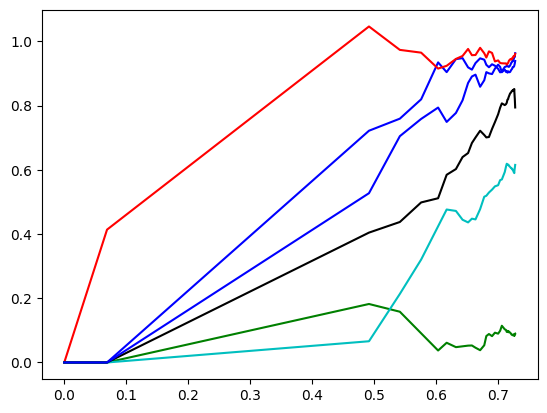

In [180]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
delta = np.mean(masks) # parameter missingness
print(delta)
X_0 = np.nan_to_num(X_nan)
S_ellp =  X_0.T @ X_0
#print("diag ", np.diag(np.diag(S)))
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
#print("matrix \n", S_ellp)
print(np.linalg.eigvalsh(S_ellp))
#print("X_nan\n", X_nan)
#print(masks)
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#print(X_ellp)
S_inv_ellp = np.linalg.inv(S_ellp)
#S_inv_ellp = S_ellp

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


0.24666666666666667
[14.2264162  15.05587539 15.11946392 15.40992039 15.42095467 24.54675207]
400 6


  3%|▎         | 6/200 [00:00<00:03, 56.44it/s]

alpha   0.0001
alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195
alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457
alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092
alpha   0.00018896523396912096


 10%|█         | 20/200 [00:00<00:02, 63.39it/s]

alpha   0.00020022003718155845
alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583
alpha   0.0002523539170434766
alpha   0.0002673841615839947
alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929
alpha   0.0004008806328898465
alpha   0.00042475715525368984


 17%|█▋        | 34/200 [00:00<00:02, 66.30it/s]

alpha   0.00045005576757004977
alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381
alpha   0.0006368249944718586
alpha   0.0006747544053110693
alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677
alpha   0.0009011018251665018
alpha   0.0009547716114208056


 24%|██▍       | 49/200 [00:00<00:02, 68.15it/s]

alpha   0.001011637979766207
alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279
alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384
alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036
alpha   0.0020255019392306666
alpha   0.0021461411978584057


 32%|███▏      | 63/200 [00:00<00:02, 66.81it/s]

alpha   0.0022739657523579274
alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605
alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828
alpha   0.004297004704320844
alpha   0.004552935074866948


 35%|███▌      | 70/200 [00:01<00:02, 63.45it/s]

alpha   0.004824108704165373
alpha   0.005111433483440166
alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393


 38%|███▊      | 77/200 [00:01<00:02, 42.19it/s]

alpha   0.007232633896483534
alpha   0.007663410868007463
alpha   0.008119844993184008
alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708
alpha   0.010234114021054537


 42%|████▏     | 83/200 [00:01<00:02, 39.36it/s]

alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072


 44%|████▍     | 88/200 [00:01<00:03, 32.83it/s]

alpha   0.014481182276745346
alpha   0.015343684089300131
alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444


 46%|████▌     | 92/200 [00:01<00:03, 29.88it/s]

alpha   0.01933891750455232
alpha   0.020490746898158482
alpha   0.021711179456945052
alpha   0.023004301197729192


 50%|████▉     | 99/200 [00:02<00:03, 25.69it/s]

alpha   0.024374441501222217
alpha   0.025826187606826773
alpha   0.02736439997074672
alpha   0.02899422853882878
alpha   0.03072112998861759
alpha   0.0325508859983506


 52%|█████▎    | 105/200 [00:02<00:03, 26.04it/s]

alpha   0.0344896226040576
alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108
alpha   0.04880251583654434


 56%|█████▋    | 113/200 [00:02<00:02, 29.76it/s]

alpha   0.05170920242896761
alpha   0.05478901179593945
alpha   0.058052255160949015
alpha   0.06150985788580504
alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272


 60%|██████    | 120/200 [00:03<00:02, 27.28it/s]

alpha   0.07752597488629465
alpha   0.0821434358491943
alpha   0.08703591361485166
alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384
alpha   0.1162322468679853


 62%|██████▏   | 123/200 [00:03<00:03, 20.54it/s]

alpha   0.12315506032928261
alpha   0.1304901978014403
alpha   0.13826221737646563


 63%|██████▎   | 126/200 [00:03<00:04, 16.20it/s]

alpha   0.14649713983072862
alpha   0.1552225357427048


 64%|██████▍   | 128/200 [00:03<00:05, 13.93it/s]

alpha   0.16446761779946645
alpha   0.17426333860096507


 66%|██████▌   | 132/200 [00:04<00:05, 11.80it/s]

alpha   0.18464249428955445
alpha   0.19563983435170648
alpha   0.2072921779595372


 67%|██████▋   | 134/200 [00:04<00:05, 11.74it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098
alpha   0.2465811075822604


 69%|██████▉   | 138/200 [00:04<00:05, 10.73it/s]

alpha   0.2612675225563329
alpha   0.27682866303920667
alpha   0.29331662783900453


 70%|███████   | 140/200 [00:05<00:05, 10.36it/s]

alpha   0.3107866187782014
alpha   0.3292971255097151


 72%|███████▏  | 143/200 [00:05<00:05,  9.62it/s]

alpha   0.3489101213406774
alpha   0.3696912707195028
alpha   0.39171014908092605


 72%|███████▎  | 145/200 [00:05<00:05,  9.32it/s]

alpha   0.41504047578504766
alpha   0.4397603609302721
alpha   0.4659525668664682


 74%|███████▍  | 148/200 [00:05<00:05,  9.57it/s]

alpha   0.4937047852839004
alpha   0.5231099308056264


 75%|███████▌  | 150/200 [00:06<00:05,  8.90it/s]

alpha   0.5542664520663108
alpha   0.5872786613189482


 76%|███████▌  | 152/200 [00:06<00:06,  7.91it/s]

alpha   0.6222570836730231
alpha   0.6593188271333549


 77%|███████▋  | 154/200 [00:06<00:06,  6.91it/s]

alpha   0.698587974678525
alpha   0.7401959996915645


 78%|███████▊  | 156/200 [00:07<00:06,  6.31it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395


 79%|███████▉  | 158/200 [00:07<00:07,  5.67it/s]

alpha   0.8804883581643465
alpha   0.9329304026284686


 80%|███████▉  | 159/200 [00:07<00:07,  5.49it/s]

alpha   0.9884959046625587


 80%|████████  | 160/200 [00:07<00:08,  4.88it/s]

alpha   1.0473708979594507


 80%|████████  | 161/200 [00:08<00:08,  4.54it/s]

alpha   1.1097524964120722


 81%|████████  | 162/200 [00:08<00:09,  3.91it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:08<00:09,  3.71it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:09<00:09,  3.68it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:09<00:09,  3.71it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:09<00:10,  3.40it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:10<00:10,  3.13it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:10<00:10,  2.98it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:10<00:10,  2.86it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:11<00:10,  2.82it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:11<00:10,  2.73it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:12<00:10,  2.62it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:12<00:10,  2.56it/s]

alpha   2.2219468609395236


 87%|████████▋ | 174/200 [00:12<00:11,  2.36it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:13<00:10,  2.28it/s]

alpha   2.4945081352303164


 88%|████████▊ | 176/200 [00:13<00:10,  2.28it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:14<00:11,  1.96it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:15<00:13,  1.63it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:16<00:13,  1.50it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:16<00:14,  1.40it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:17<00:12,  1.52it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:18<00:10,  1.65it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:18<00:09,  1.76it/s]

alpha   3.9626886387014784
